# Курсовая работа
Выполнил: Батов Алексей
М8О-109СВ-24

Датасет: [NYC Taxi Trip Data](https://www.kaggle.com/datasets/neilclack/nyc-taxi-trip-data-google-public-data/data)

## NYC Taxi Trip Data
Датасет является подмножеством общедоступных наборов данных Google BigQuery — набор данных о поездках такси Нью-Йорка. Задача регрессии на табличных данных для предсказания итоговой стоимости поездки.

Датасет состоит из следующих колонок:
- trip_distance — дистанция поездки
- rate_code — код тарифа
- payment_type — тип оплаты
- fare_amount — стоимость поездки без надбавок и чаевых
- extra — дополнительные сборы
- mta_tax — налог
- tip_amount — чаевые
- tolls_amount — сумма за платные участки дороги
- imp_surcharge — импортный сбор
- total_amount — общая сумма поездки с учётом всех надбавок
- pickup_location_id — ID места посадки
- dropoff_location_id — ID места высадки
- year — год поездки
- month — месяц поездки
- day — день месяца
- day_of_week — день недели
- hour_of_day — час начала поездки
- trip_duration — длительность поездки в минутах

Используется 200 000 записей из датасета.





## Импорт библиотек

In [14]:
!pip install catboost
!pip install lime

In [15]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import kagglehub
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

## Загрузка и подготовка данных

In [16]:
path = kagglehub.dataset_download("neilclack/nyc-taxi-trip-data-google-public-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/nyc-taxi-trip-data-google-public-data


In [17]:
df = pd.read_csv("/kaggle/input/nyc-taxi-trip-data-google-public-data/original_cleaned_nyc_taxi_data_2018.csv")

df = df.drop(columns=["Unnamed: 0", 'store_and_fwd_flag','calculated_total_amount'])

df = df.dropna()
df = df[df['total_amount'] > 0]
df = df[df['fare_amount'] > 0]
df = df[df['trip_distance'] > 0]
df = df[df['trip_duration'] > 0]

df=df.sample(n=200000, random_state=42)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 3889775 to 5006849
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_distance        200000 non-null  float64
 1   rate_code            200000 non-null  int64  
 2   payment_type         200000 non-null  int64  
 3   fare_amount          200000 non-null  float64
 4   extra                200000 non-null  float64
 5   mta_tax              200000 non-null  float64
 6   tip_amount           200000 non-null  float64
 7   tolls_amount         200000 non-null  float64
 8   imp_surcharge        200000 non-null  float64
 9   total_amount         200000 non-null  float64
 10  pickup_location_id   200000 non-null  int64  
 11  dropoff_location_id  200000 non-null  int64  
 12  year                 200000 non-null  int64  
 13  month                200000 non-null  int64  
 14  day                  200000 non-null  int64  
 15  day_of_week    

trip_distance  rate_code  payment_type  fare_amount  extra  mta_tax  \
3889775           7.40          1             2         28.0    0.5      0.5   
6908713           9.00          1             1         27.5    0.5      0.5   
4149018           7.80          1             1         23.5    0.5      0.5   
6816202          11.78          1             1         33.0    0.5      0.5   
6140876           8.43          1             1         24.5    0.0      0.5   

         tip_amount  tolls_amount  imp_surcharge  total_amount  \
3889775        0.00           0.0            0.3         29.30   
6908713        5.75           0.0            0.3         34.55   
4149018        3.72           0.0            0.3         28.52   
6816202        6.86           0.0            0.3         41.16   
6140876        2.00           0.0            0.3         27.30   

         pickup_location_id  dropoff_location_id  year  month  day  \
3889775                  48                   82  2018      3   27   
6908713                 261                  202  2018     12    3   
4149018                 186                  116  2018     10   17   
6816202                 138                   64  2018      5    4   
6140876                  13                  263  2018     11   12   

         day_of_week  hour_of_day  trip_duration  
3889775            1            0         2876.0  
6908713            0           22         2433.0  
4149018            2            3         3469.0  
6816202            4           23         1549.0  
6140876            0           19         2702.0

In [18]:
features = [
    'trip_distance', 'trip_duration', 'hour_of_day', 'day_of_week',
    'pickup_location_id', 'dropoff_location_id', 'rate_code',
    'payment_type', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'imp_surcharge'
]
target = 'total_amount'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение модели CatBoost

In [19]:
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 6.538632996952866


## SHAP

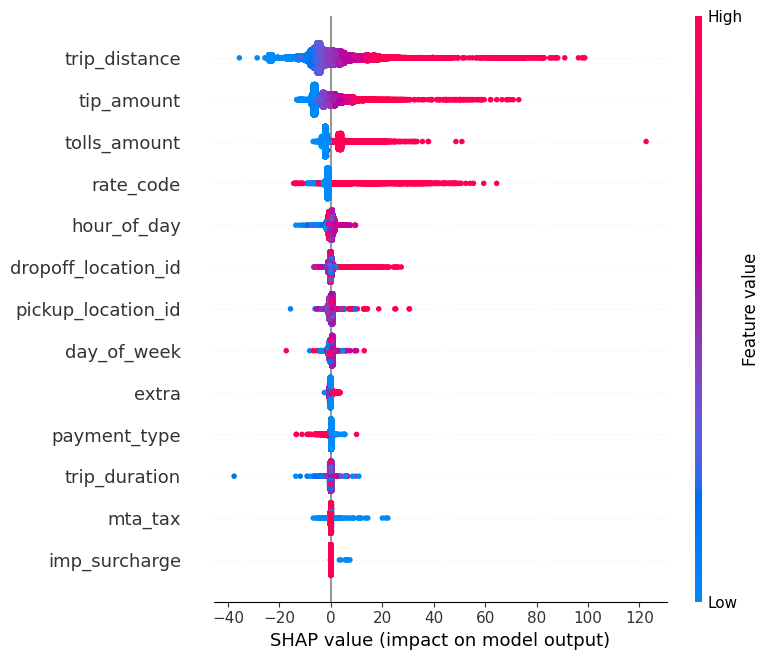

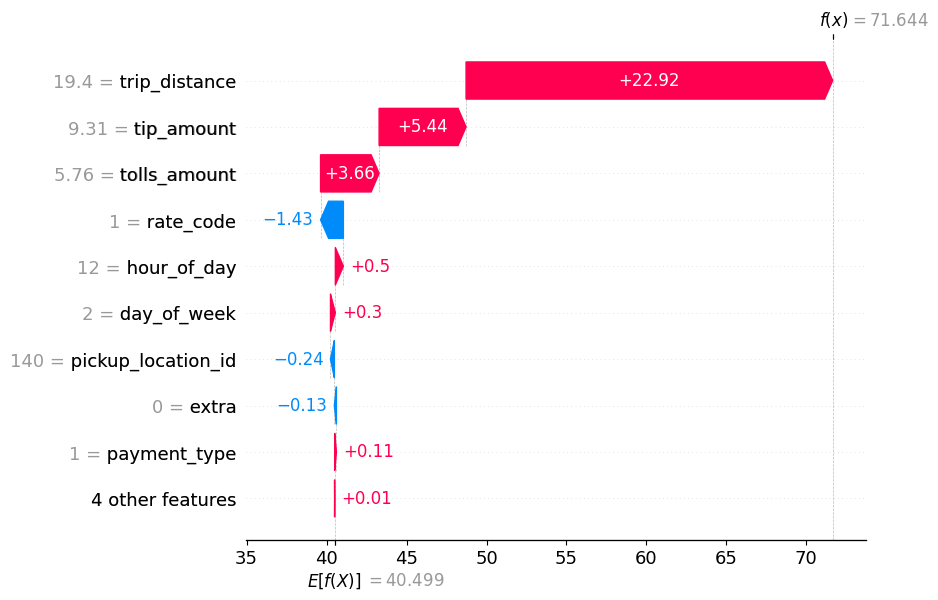

In [25]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

shap.plots.waterfall(shap_values[2])

SHAP-анализ показал, что наиболее важными признаками для предсказания стоимости поездки являются:
- trip_distance (дистанция поездки)
- tip_amount (чаевые)
- tools_amount(доп)

Самые важные признаки: дистанция поездки, чаевые, платные дороги.
Модель в основном основывается на финансовых и дистанционных характеристиках.
Время поездки, локации и прочие признаки имеют умеренное или низкое влияние.
Малозначимые признаки можно потенциально отбросить.

Локальная интерпретация подтверждает результаты глобальной.

## LIME

In [26]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

exp = lime_explainer.explain_instance(X_test.iloc[0].values, model.predict)
exp.show_in_notebook()

На основе предоставленного анализа LIME для конкретной поездки можно выделаить ключевые влияющие факторы:
- trip_distance: Расстояние поездки имеет значительный отрицательный вклад, что снижает стоимость;
- rate_code: Тарифный код 1.00 также снижает предсказание;
- tip_amount: Сумма чаевых имеет отрицательный эффект, так как отсутствие чаевых уменьшает общую стоимость;
- hour_of_day: Время поездки (18:00) положительно влияет, повышая стоимость;
- payment_type: Тип оплаты 1.00 даёт небольшой положительный вклад.

Основной вклад в снижение предсказанной стоимости вносят умеренное расстояние, стандартный тариф и отсутствие чаевых и сборов. Положительное влияние связано с временем суток и типом оплаты, что частично компенсирует снижение.

## PFI (Доп. метод)

                feature  importance_mean  importance_std
0         trip_distance         0.569918        0.002586
10           tip_amount         0.180127        0.001776
6             rate_code         0.146844        0.001506
11         tolls_amount         0.054390        0.002566
5   dropoff_location_id         0.018699        0.001879
2           hour_of_day         0.006877        0.001792
8                 extra         0.001900        0.000211
4    pickup_location_id         0.001802        0.001722
3           day_of_week         0.001173        0.000766
12        imp_surcharge         0.000015        0.000010
1         trip_duration        -0.001440        0.001876
9               mta_tax        -0.001514        0.000565
7          payment_type        -0.003282        0.001871


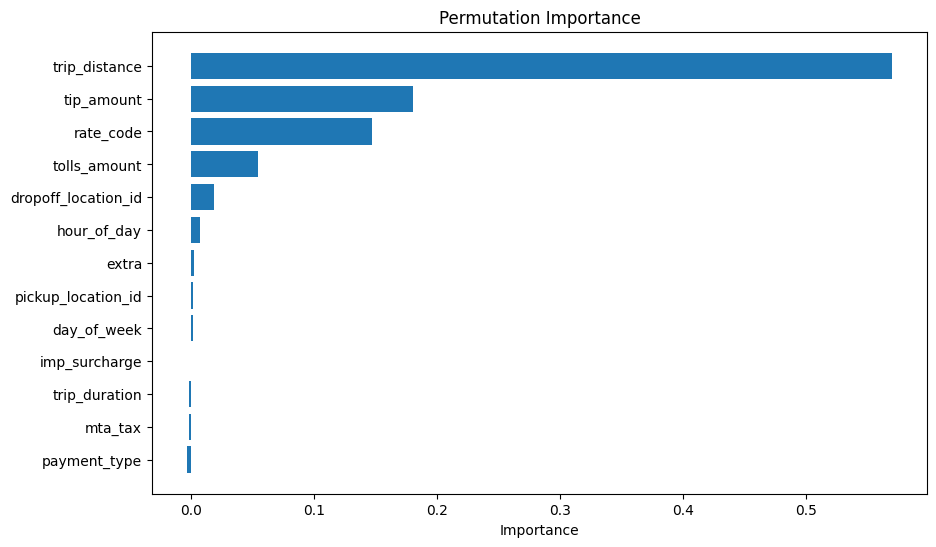

In [22]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(perm_df)

plt.figure(figsize=(10,6))
plt.barh(perm_df['feature'], perm_df['importance_mean'])
plt.xlabel('Importance')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.show()

Порядок признаков совпадает с SHAP.
Permutation Importance измеряет, насколько ухудшается качество модели при случайном перемешивании значений признака. Высокая важность trip_distance и tip_amount указывает на их критическую роль в предсказании total_amount.

Permutation Importance подтверждает результаты SHAP, подчеркивая ключевую роль дистанции и чаевых

## Интерпретация собственной записи

Предсказанная стоимость поездки:  27.12


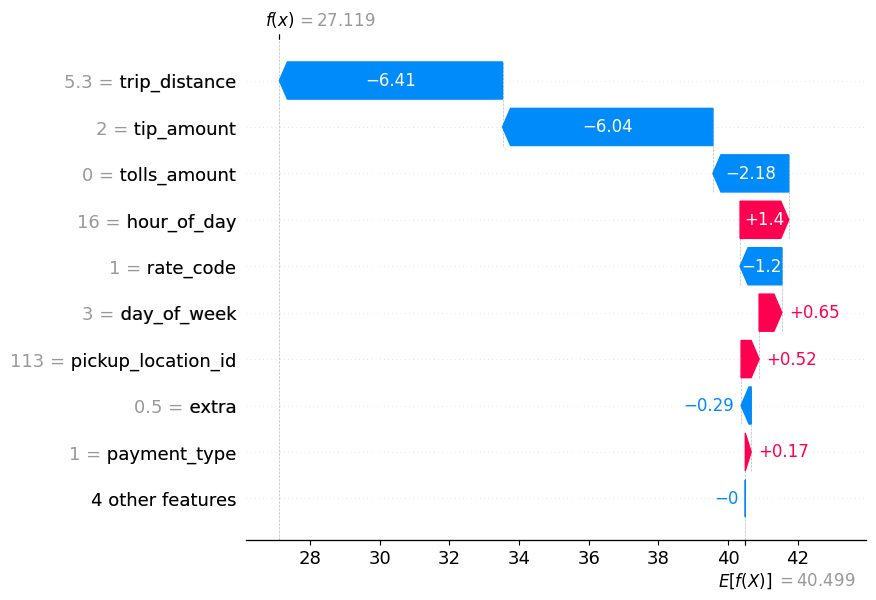

In [33]:
my_trip = pd.DataFrame([{
    'trip_distance': 5.3,
    'trip_duration': 900,
    'hour_of_day': 16,
    'day_of_week': 3,
    'pickup_location_id': 113,
    'dropoff_location_id': 161,
    'rate_code': 1,
    'payment_type': 1,
    'extra': 0.5,
    'mta_tax': 0.5,
    'tip_amount': 2,
    'tolls_amount': 0.0,
    'imp_surcharge': 1.0
}])

predicted_fare = model.predict(my_trip)[0]
print("Предсказанная стоимость поездки: ", round(predicted_fare, 2))

shap_values_custom = explainer(my_trip)
shap.plots.waterfall(shap_values_custom[0])

Для тестовой записи  модель предсказала стоимость  27.12. Признак trip_distance уменьшил предсказание на 6.41, tip_amount уменьшил на 6.04.Признак hour_of_day=16 слегка увеличил предсказание на 1.4.

Итоговое предсказание (27.119) ниже среднего (40.499) в основном из-за умеренного расстояния поездки, низких чаевых и отсутствия сборов за дороги. Положительный вклад времени суток, тарифного кода и дня недели частично компенсирует снижение, но не приводит к стоимости выше средней.

In [28]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression'
)

my_trip_array = my_trip.values[0]
lime_exp = lime_explainer.explain_instance(my_trip_array, model.predict, num_features=len(X_train.columns)
)

lime_exp.show_in_notebook()

Ключевые факторы:
- trip_distance: Расстояние поездки имеет наибольший отрицательный вклад, что значительно снижает стоимость
- rate_code: Стандартный тарифный код также сильно снижает предсказание
- tip_amount: Сумма чаевых имеет отрицательный эффект
- imp_surcharge: Вносит положительный вклад в предсказание
- hour_of_day: Время поездки также положительно влияет.

Основное снижение предсказанной стоимости связано с умеренным расстоянием поездки, тарифом и небольшими чаевыми, что совпадает с результатами SHAP

## Вывод

Анализ SHAP, LIME и PFI демонстрирует частичное совпадение: все методы выделяют ключевые признаки, влияющие на стоимость поездки, но различаются в величинах. При глобальной и локальной интерпретации SHAP и LIME пришли к согласованному выводу, указывая на значимость определенных признаков.